## Original functions from Lucy

In [1]:
def MinimumSkew(genome):
   skew = Skew(genome)
   value = min(skew.values())
   minimum = []
   for i in skew:
       if skew[i] == value:
           minimum.append(i)
   return minimum

In [2]:
def Skew(Genome):
   array = {}
   n = len(Genome)
   array[0] = 0
   for i in range(len(Genome)):
       array[i+1] = array[i]
       if Genome[i] == 'C':
           array[i+1] = array[i+1]-1
       if Genome[i] == 'G':
           array[i+1] = array[i+1]+1
   return array

## Generating test data

In [3]:
from random import choice

In [4]:
def build_random_genome(size):
    bases = ['A', 'C', 'G', 'T']
    genome = [choice(bases) for _ in range(size)]
    return "".join(genome)

In [5]:
# generate test genome of 65000 lines * 80 chars per line
sequence = build_random_genome(65000*80)
# write genome to file
with open('f', 'w') as f:
    f.write(sequence)

In [6]:
# read test genome from file as bytes sequence
with open('f', 'rb') as f:
    test_genome_bytes = f.read()

In [7]:
# string representation of test sequence, for Lucy and Python functions
test_genome_str = test_genome_bytes.decode()

## Reimplementation

### Python

In [8]:
# first, an implementation in pure Python, for reference
def min_skew_python(genome):
    gs, cs, min_skew = 0, 0, 0
    indices = []
    for i, base in enumerate(genome, 1):
        if base == 'G':
            gs += 1
        elif base == 'C':
            cs += 1
        skew = gs - cs
        if skew < min_skew:
            min_skew = skew
            indices = [i]
        elif skew == min_skew:
            indices.append(i)
    return indices

### Numpy

In [9]:
import numpy as np

In [10]:
def min_skew_numpy(genome):
    # load sequence into numpy array
    aseq = np.frombuffer(genome, dtype=np.dtype('S1')).view(np.int8)

    # cumulative sums of 'G' and 'C' bases in the sequence
    dt = np.int32 if len(genome) < 2**32 -1 else np.int64
    g_cum_sum = np.cumsum(aseq == ord('G'), dtype=dt)
    c_cum_sum = np.cumsum(aseq == ord('C'), dtype=dt)
    
    # skew is the difference of the two sums
    skews = g_cum_sum
    skews -= c_cum_sum
    
    # get the minimum skew from skews
    min_skew = skews.min()
    # if it is not negative, set it to 0
    min_skew = min_skew if min_skew < 0 else 0
    
    # return the indices of all the minimum values in skews, shifted by 1
    return np.where(skews == min_skew)[0] + 1

## Testing

### Correctness

In [11]:
MinimumSkew(test_genome_str)

[563413, 563431]

In [12]:
min_skew_python(test_genome_str)

[563413, 563431]

In [13]:
min_skew_numpy(test_genome_bytes)

array([563413, 563431])

### Speed

In [14]:
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set_style("whitegrid")

In [15]:
# Lucy
time_lucy = %timeit -o MinimumSkew(test_genome_str)

1 loop, best of 3: 3.17 s per loop


In [16]:
# pure Python version
time_python = %timeit -o min_skew_python(test_genome_str)

1 loop, best of 3: 1.31 s per loop


In [17]:
# numpy-based version
time_numpy = %timeit -o min_skew_numpy(test_genome_bytes)

10 loops, best of 3: 86.2 ms per loop


In [18]:
d = {'times': pd.Series([time_lucy.best, time_python.best, time_numpy.best]),
     'names': pd.Series(['Lucy', 'Python', 'Numpy'])}
df = pd.DataFrame(d)

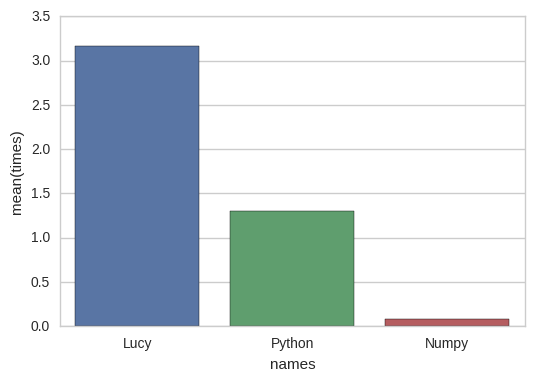

In [19]:
ax = sns.barplot(x='names', y='times', data=df)

### Memory

In [20]:
%load_ext memory_profiler

In [21]:
%memit test_genome_str

peak memory: 139.57 MiB, increment: 0.02 MiB


In [22]:
# Lucy
%memit MinimumSkew(test_genome_str)

peak memory: 612.70 MiB, increment: 473.12 MiB


In [23]:
# pure Python version
%memit min_skew_python(test_genome_str)

peak memory: 186.69 MiB, increment: 0.00 MiB


In [24]:
# numpy-based version
%memit min_skew_numpy(test_genome_bytes)

peak memory: 204.05 MiB, increment: 17.22 MiB


In [25]:
# the initial test sequence occupies 73 MiB. 
# Lucy's code generates a furter 429 MiB on top of that!
# The new python code is O(1) space complexity, so no new space is occupied
# The numpy version is somewhere in between, at 64 Mib extra